## 라이브러리 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

## 데이터 가져오기

In [15]:
import pandas as pd

raw_url = "https://raw.githubusercontent.com/upul/WhiteBoard/master/data/daily-minimum-temperatures-in-me.csv"

# CSV 읽기
df = pd.read_csv(
    raw_url,
    quotechar='"',
    on_bad_lines='skip',
    parse_dates=['Date'],
    index_col='Date'
)
df.rename(columns={
    'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp'
}, inplace=True)

df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [16]:
ts = df['Temp']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: object

In [17]:
ts = pd.to_numeric(ts, errors='coerce') 
print(ts.dtypes)

float64


## 결측치 처리
- 모두 삭제✅
- 보간 

In [18]:
# 결측치 처리
# print("결측치 개수:", ts.isna().sum())

In [19]:
# ts = ts.dropna()

## 시계열 데이터의 정상성 분석

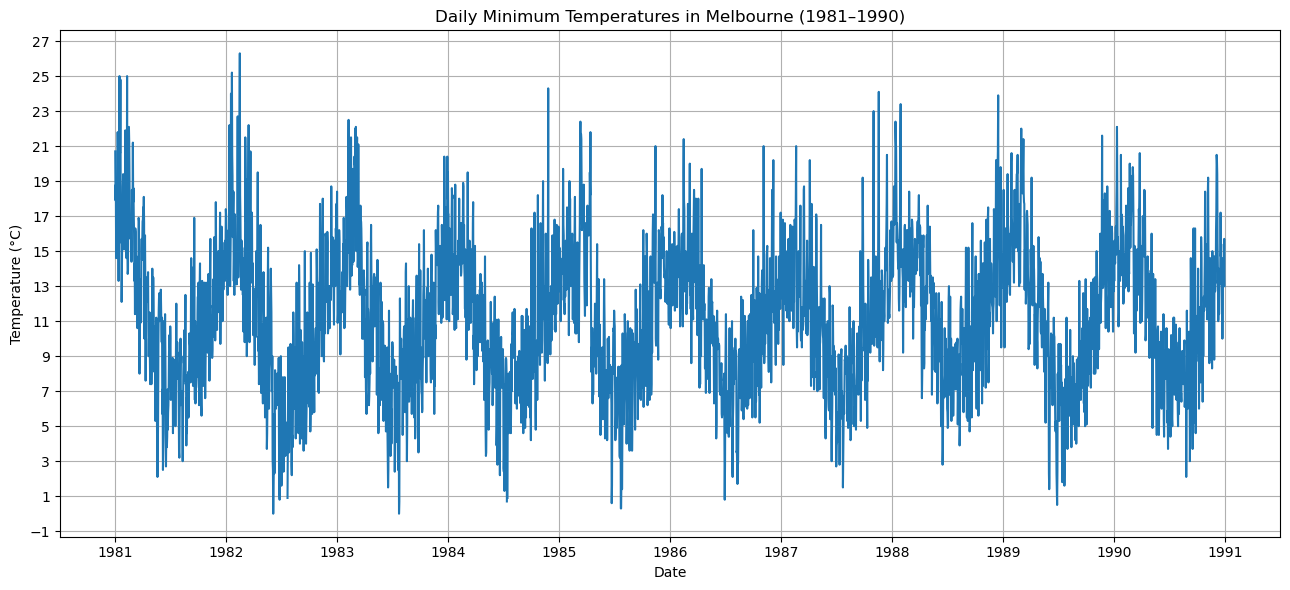

In [20]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (13, 6)

plt.plot(ts)

# ts의 최소값보다 1작게, 최대값보다 1크게, 간격은 2로 y축 눈금을 만든다.
yticks = np.arange(int(ts.min()) - 1, int(ts.max()) + 2, 2)
plt.yticks(yticks)

plt.title("Daily Minimum Temperatures in Melbourne (1981–1990)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 결측치 처리
- 모두 삭제
- 보간 ✅

In [26]:
ts[ts.isna()]

Date
1982-07-20   NaN
1982-07-21   NaN
1984-07-14   NaN
Name: Temp, dtype: float64

In [27]:
print(ts.isna().sum())

3


0


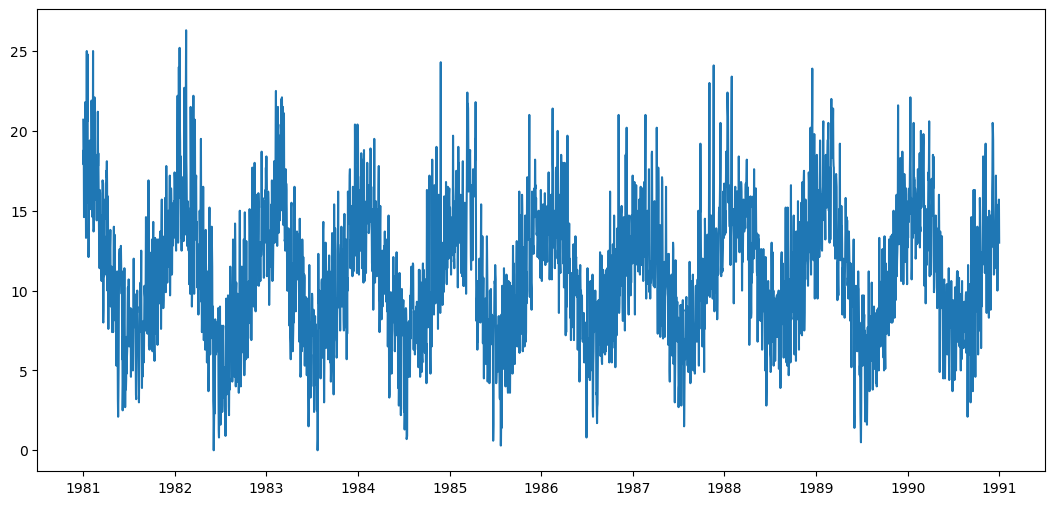

In [28]:
ts=ts.interpolate(method='time')
print(ts.isna().sum())
plt.plot(ts)

### 시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는가?

In [47]:
# 시계열 데이터 정상성 확인 
# 이동 평균 & 이동 표준편차를 통해 시계열의 변동성을 분석 

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

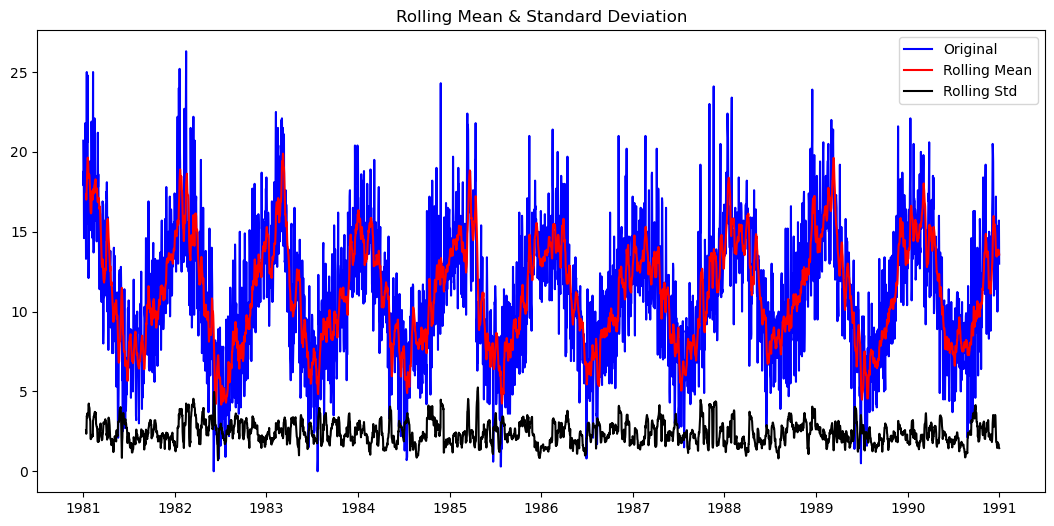

In [32]:
plot_rolling_statistics(ts, window=12)

평균값이 시간에 따라 크게 변하지 않고, 데이터의 분산이 일정하다.

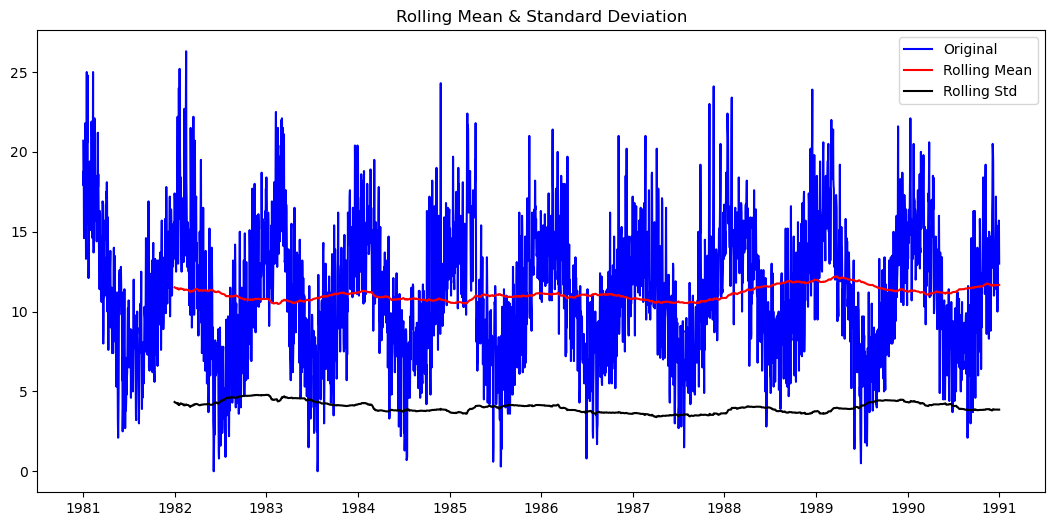

In [48]:
plot_rolling_statistics(ts, window=365) # 1년을 기준으로 

시계열 데이터의 평균과 표준편차가 시간에 따라 거의 변하지 않는다.

## 다른 데이터로도 비교해보기

In [35]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, index_col='Month', parse_dates=True).fillna(0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


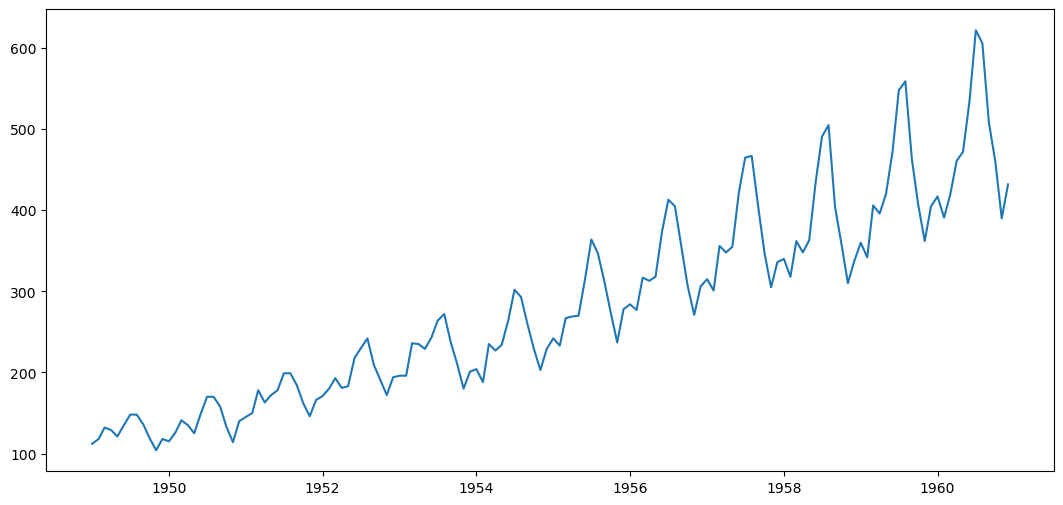

In [36]:
ts2 = df['Passengers']
plt.plot(ts2)

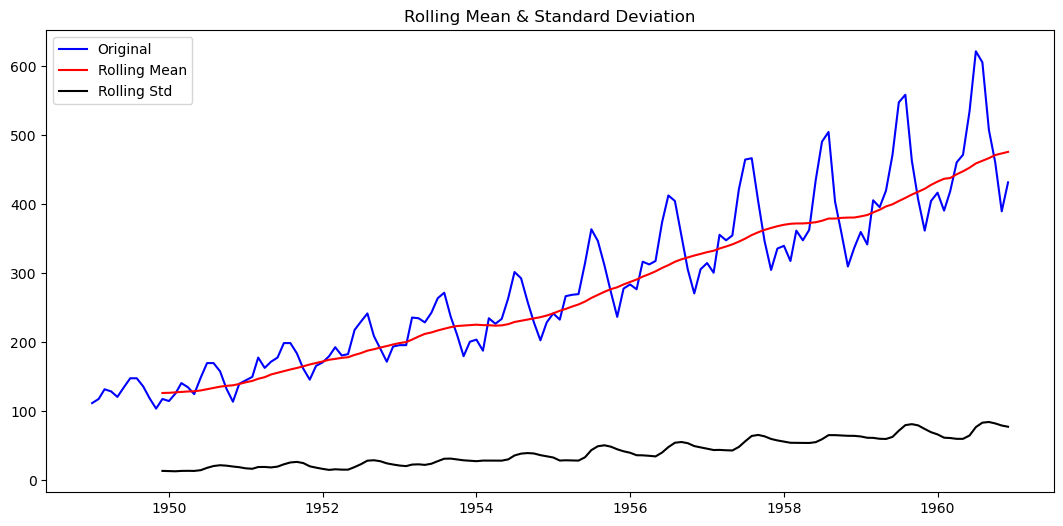

In [37]:
plot_rolling_statistics(ts2, window=12)

이동 평균이 점차 상승하는 것으로 보아, 시간이 지날수록 평균 승객 수가 증가하는 상승 추세가 있다.  
이동 표준편차도 살짝 상승되어 데이터의 변동성도 점점 커지고 있다.  
-> 정상성의 조건을 만족하지 않는 데이터

In [38]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')

    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### Dickey-Fuller Test 해석 요령
시계열이 정상인지 아닌지를 판단하는 통계적 검정  
- p-value < 0.05 -> 정상 시계열
- Test Statistic < Critical Value(1%,5%,10%) -> 정상 시계열

In [41]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -4.440522
p-value                           0.000251
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


p-value값이 0.05보다 작으므로 귀무가설은 기각되고 대립가설이 채택되어  
정상 시계열 데이터라고 볼 수 있다.

In [42]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value값이 0.05보다 크므로 귀무가설을 기각할 수 없게 되었으므로  
비정상 시계열 데이터라고 볼 수 있다.

## 정상성 변환
- 로그 변환하여 전체적인 상승 폭 줄이기

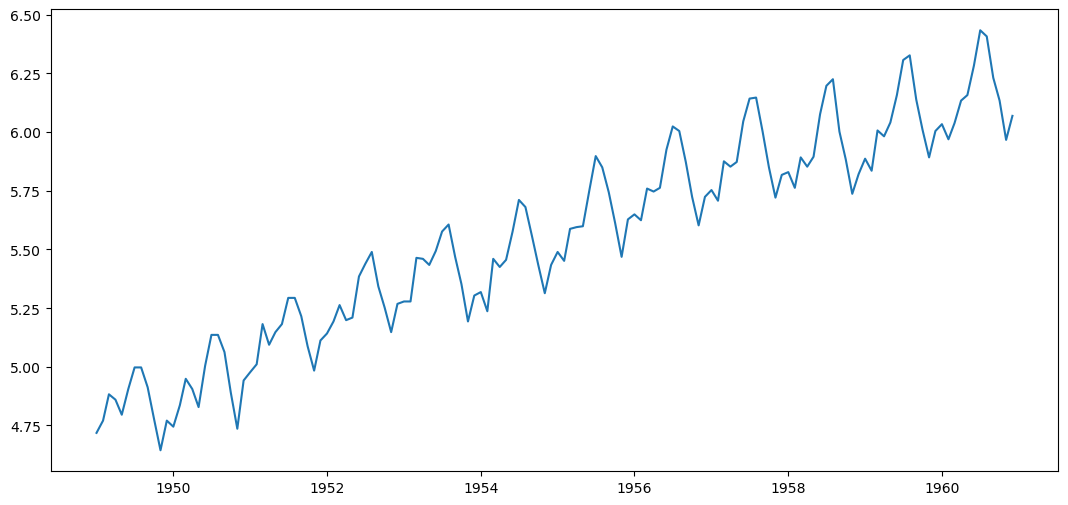

In [43]:
ts_log = np.log(ts2)
plt.plot(ts_log)

Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다. 

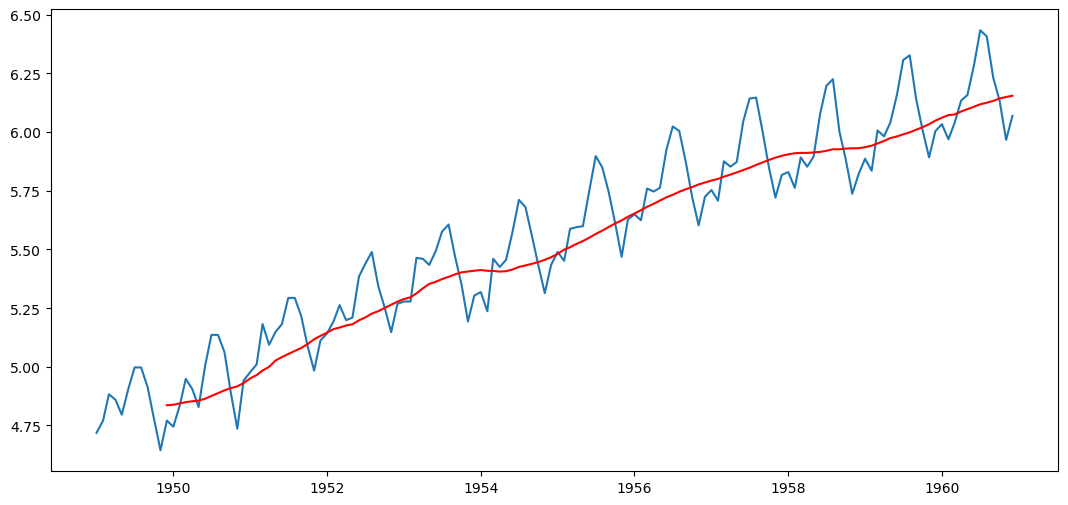

In [45]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [44]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 절반 이상 줄어들었지만 아직 시간 추이에 따라 평균이 계속 증가한다.

## 추세 제거
- 이동 평균 제거

In [50]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

### 결측치 제거

In [51]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

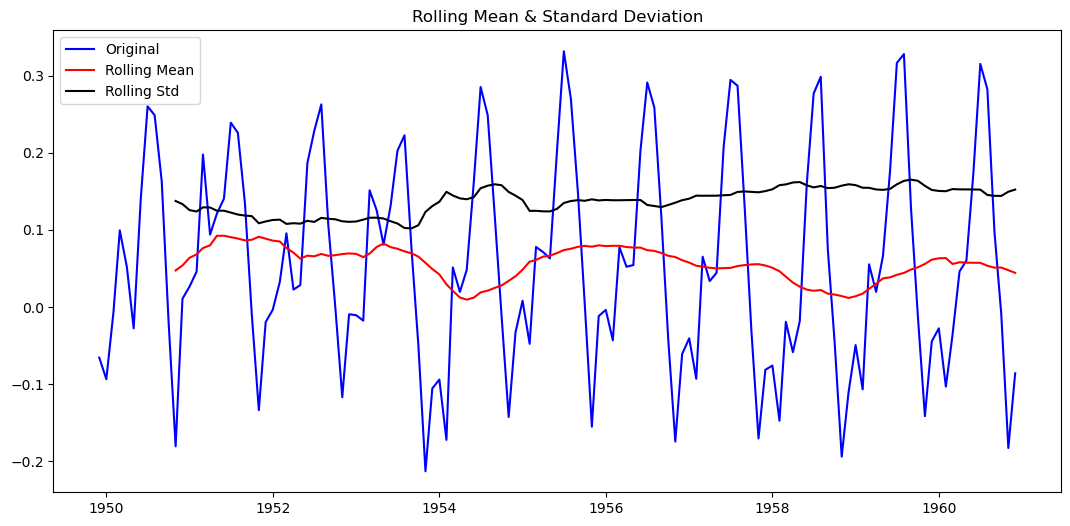

In [52]:
plot_rolling_statistics(ts_log_moving_avg)

In [53]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 하는데  
window=6 을 적용한다면?

In [55]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

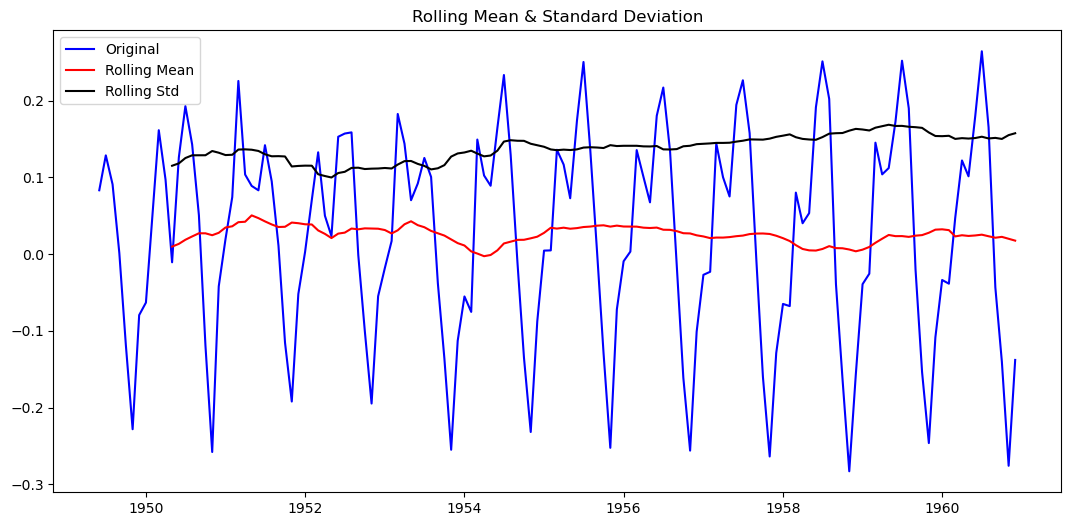

In [56]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [57]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


widnow=6이 되면 p-value가 0.18로 정상성 시계열이라고 말할 수 없게 된다.  
moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다.  

## 차분
- 계절성 상쇄

### 한 칸 시프트한 데이터 시각화

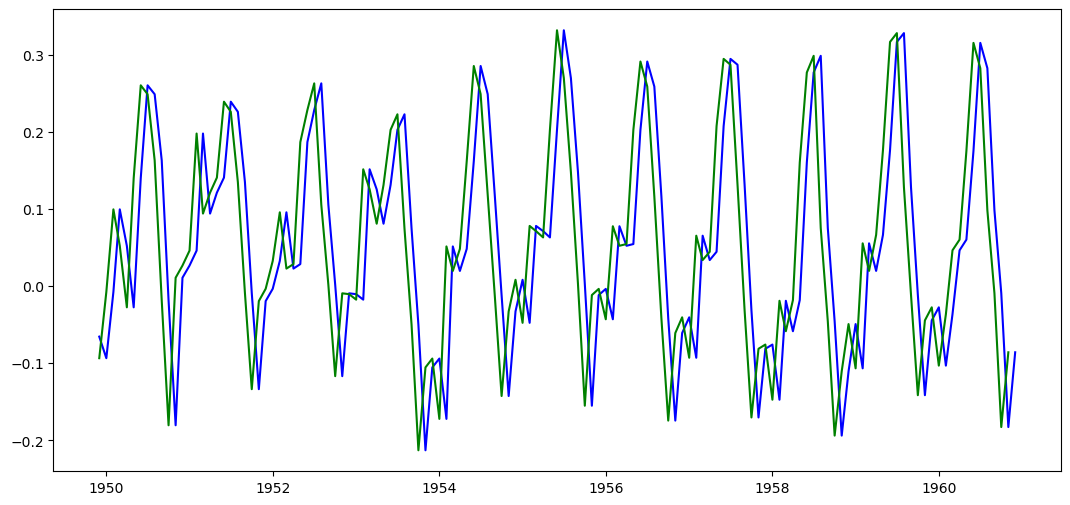

In [58]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

### 변화량(차분) 계산

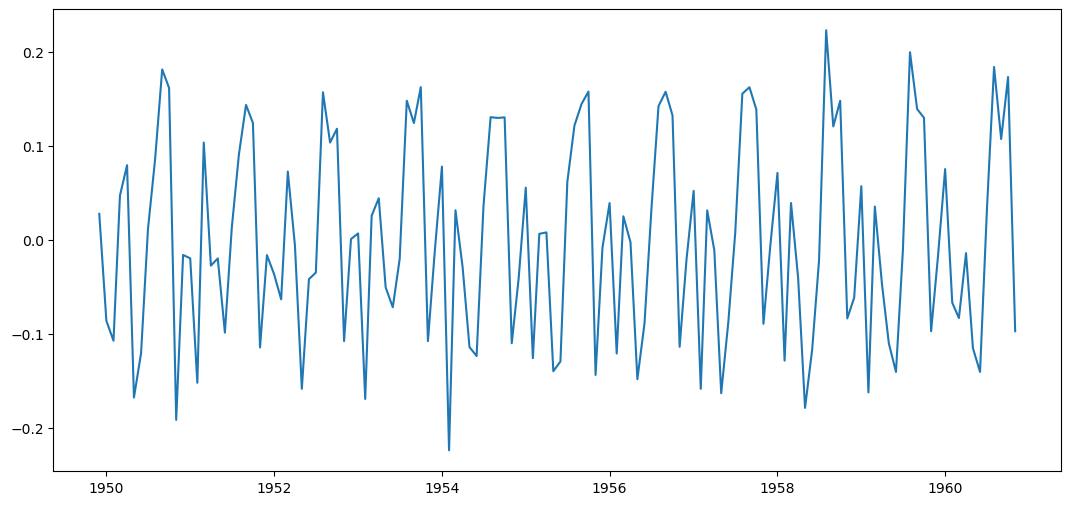

In [59]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

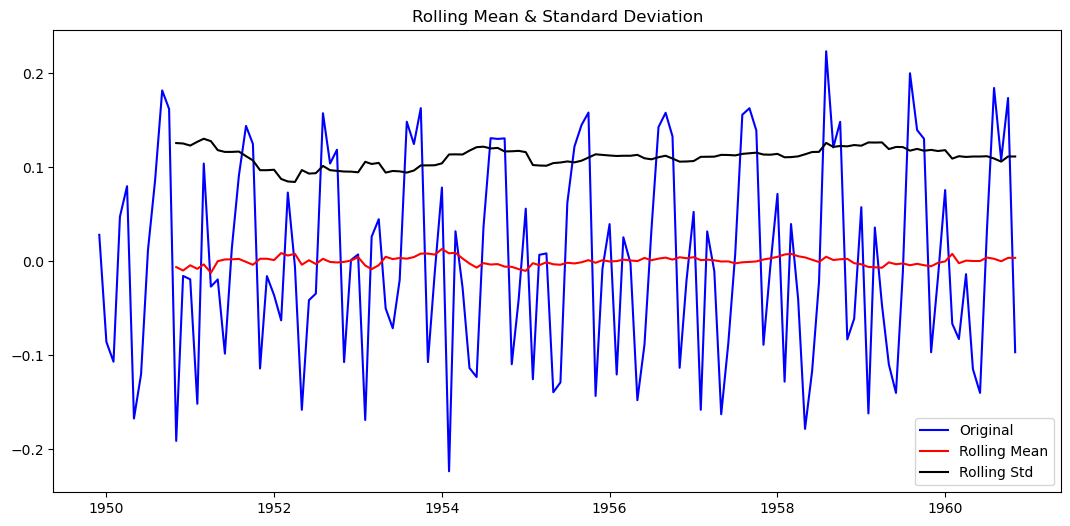

In [60]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [61]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


로그함수 변환한 데이터에서 이동평균을 빼 주어 추세를 제거하고 난 시계열에다가  
1차 차분을 적용하여 계절성 효과를 다소 상쇄시켰다.  
  
p-value값이 0.05보다 작으므로 귀무가설을 기각하고 대립가설을 채택할 수 있다.  
즉, 정상성 데이터라고 볼 수 있다.  

데이터에 따라서는 2차 차분, 3차 차분을 적용하면 더욱 p-value값을 낮출 수 있다.

## 시계열 분해 time series decomposition
statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리  
위에서 작업했던 이동 평균 제거, 추세 제거 등을 거치지 않고도 간결하게 표현할 수 있다.

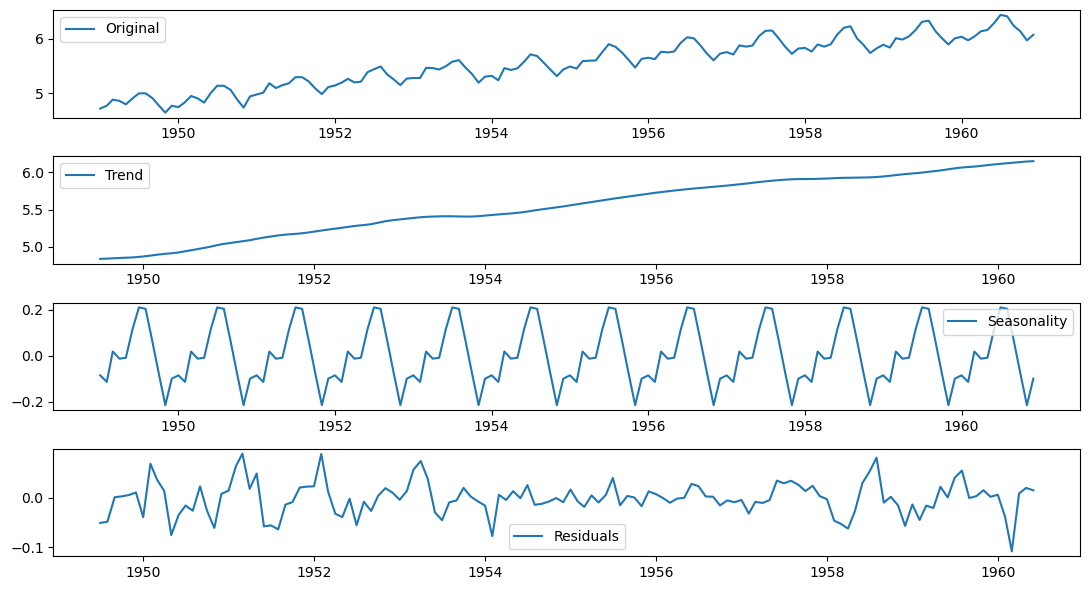

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

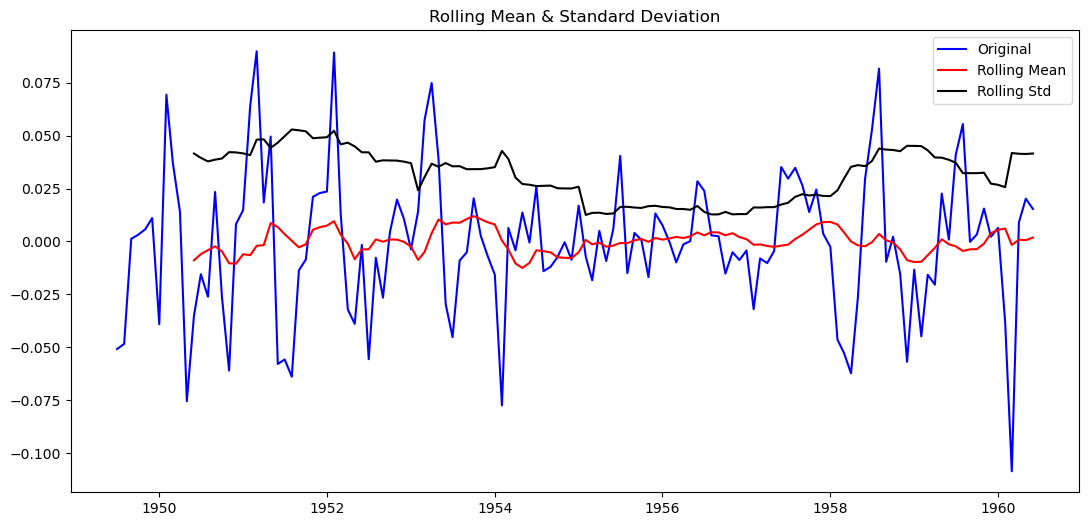

In [63]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [64]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [69]:
# p-value 2.885059e-08 -> 0.00000002885059

정상성 데이터라고 볼 수 있다.

## ARIMA
- 모수 p, d, q -> ACF or PACF 기법  
- ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정
- p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻이다.  
  이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

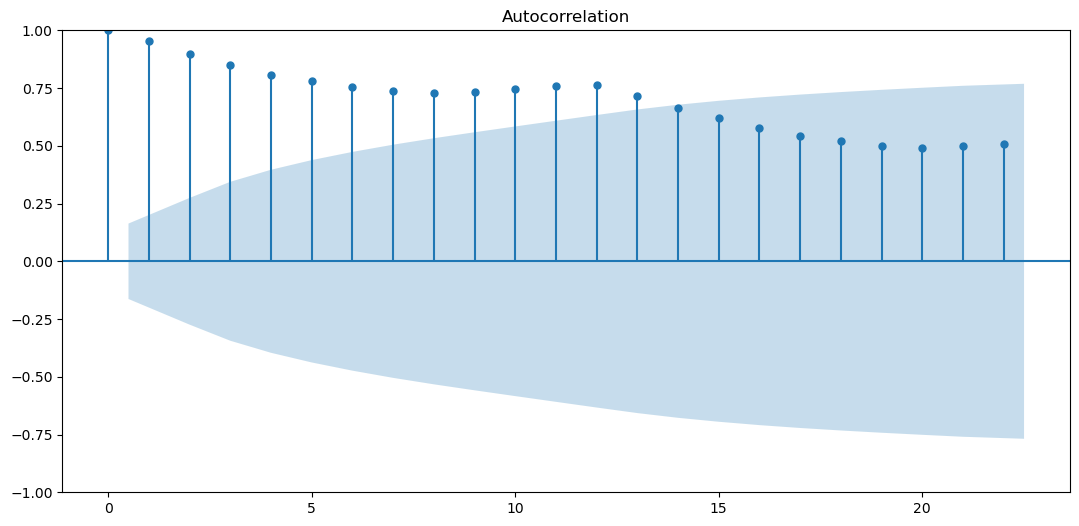

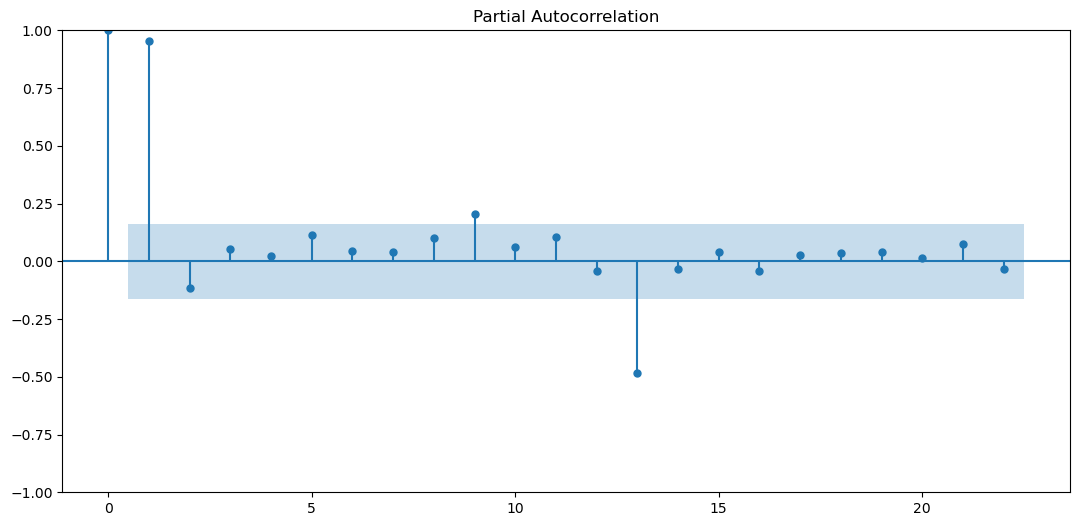

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다.  
q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다.  

PACF 그래프를 볼 때 p=1이 매우 적합하다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.  
하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠다.

### 1차 차분

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


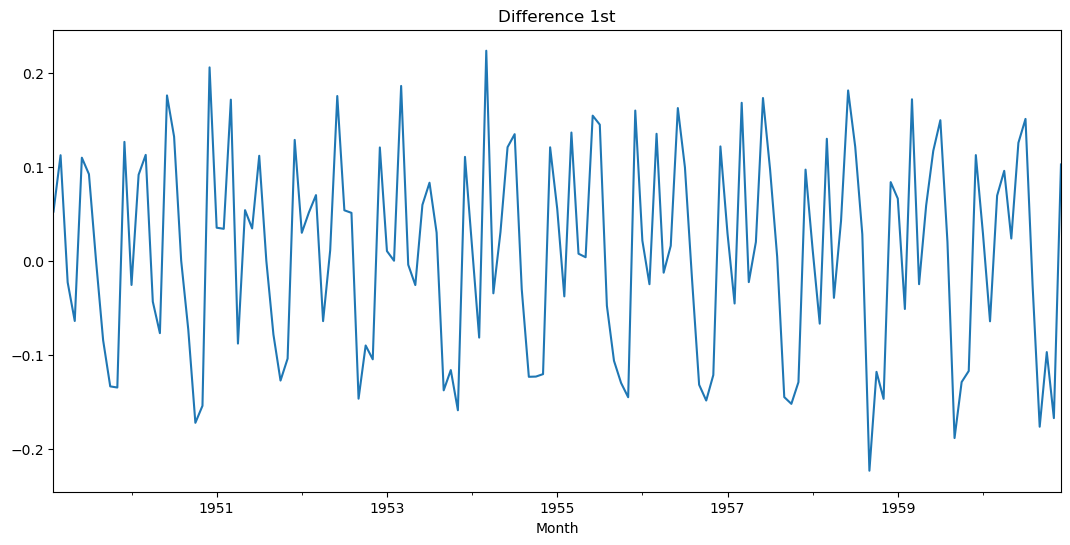

In [71]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 2차 차분

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


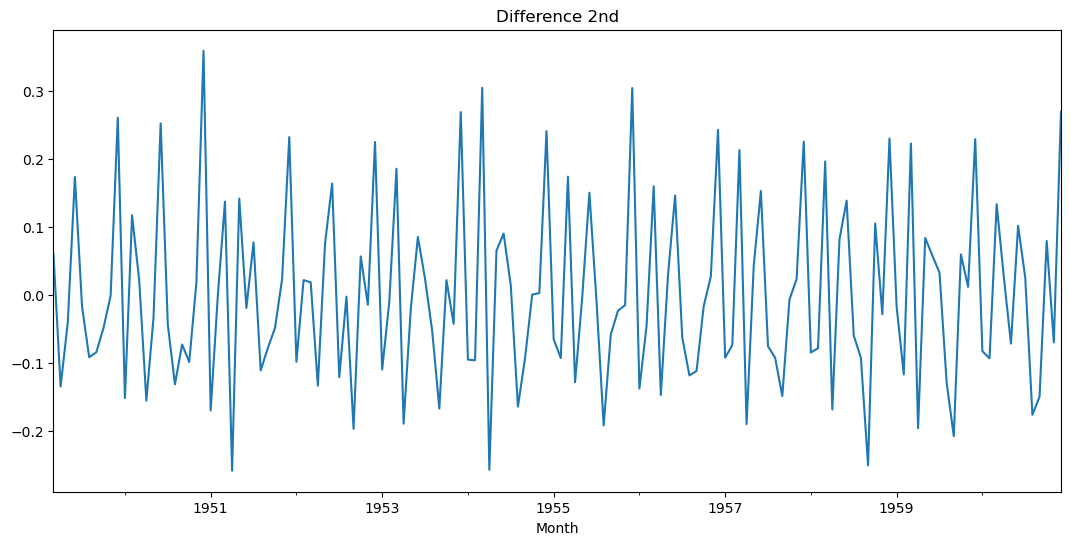

In [75]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [73]:
# p-value  0.0000000000007419305

1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였다.  
2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있을 것 같다.  
d 값도 바꿔 가면서 최적의 값을 찾아보기를 권합니다.  
(여기서 d값은 차분의 횟수를 말함)

## 학습 데이터 분리

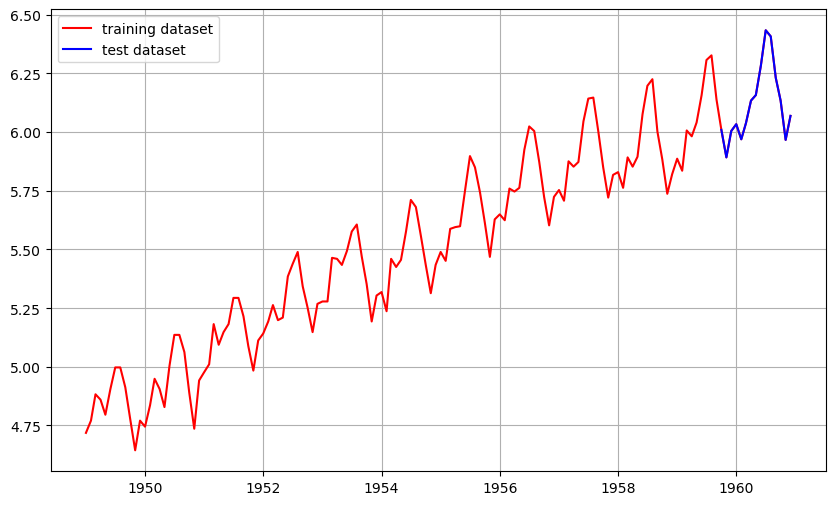

In [76]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [77]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


In [78]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# 모델 생성
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.951
Date:                Tue, 27 May 2025   AIC                           -409.902
Time:                        12:23:57   BIC                           -367.121
Sample:                    01-01-1949   HQIC                          -392.520
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2789      0.081     -3.444      0.001      -0.438      -0.120
ar.L2         -0.0134      0.108     -0.123      0.902      -0.226       0.199
ar.L3         -0.0015      0.046     -0.032      0.9

In [79]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# 모델 생성
model = ARIMA(train_data, order=(13, 1, 0)) # 모수는 이전 그래프를 참고
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(13, 1, 0)   Log Likelihood                 219.662
Date:                Tue, 27 May 2025   AIC                           -411.325
Time:                        12:29:50   BIC                           -371.397
Sample:                    01-01-1949   HQIC                          -395.102
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2900      0.072     -4.031      0.000      -0.431      -0.149
ar.L2         -0.0636      0.056     -1.135      0.256      -0.173       0.046
ar.L3       7.285e-05      0.044      0.002      0.9

AIC, BIC 는 값이 작을수록 좋음.  
Log Likelihood는 값이 클수록 좋음.  

ACF는 천천히 줄고, PACF는 특정 시점에서 급격히 끊김 → AR 모델이 적합  
따라서 ARIMA(13,1,0) 혹은 차분된 데이터로 AR(13)이 적합하다고 판단.  

🔍 PACF 그래프 분석 다시 보기  
lag 1, 2는 확실히 높고 유의미함 (기대한 대로).  
  
그 이후 대부분은 파란 신뢰구간 안에 들어감 → 통계적으로 유의하지 않음.  

다만, lag 13에서 음의 방향으로 신뢰구간 밖으로 튀어나옴  
→ 이건 통계적으로 유의미한 피크이므로 p=14와 p=13을 비교해보기로 함.


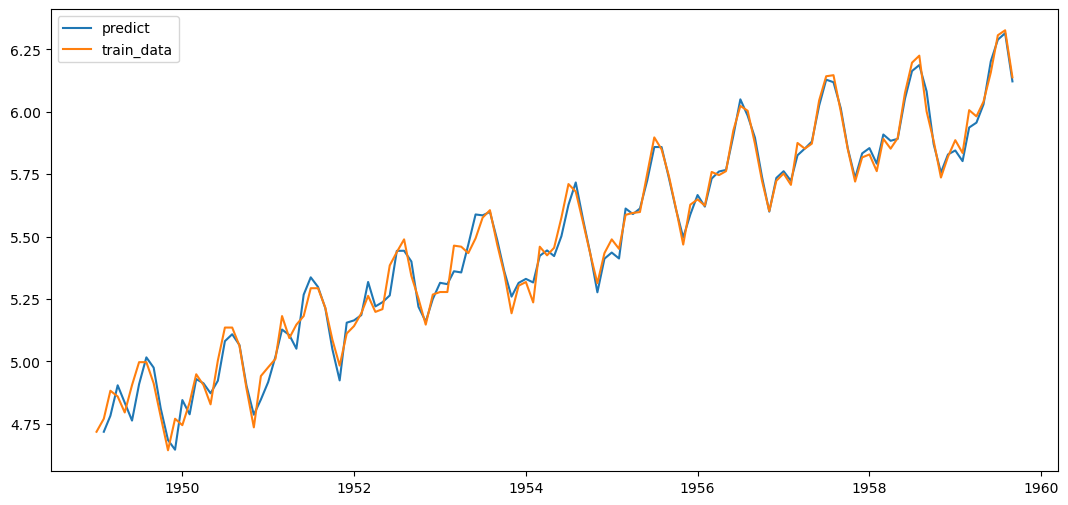

In [80]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

## 로그 변환 -> 지수 변환하여 정확한 오차 계산

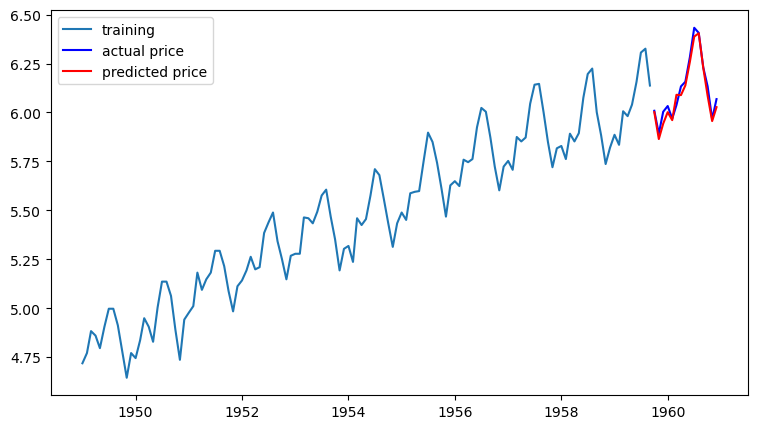

In [86]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit()
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  235.56810381733703
MAE:  12.584816877721618
RMSE:  15.348228035096984
MAPE: 2.77%


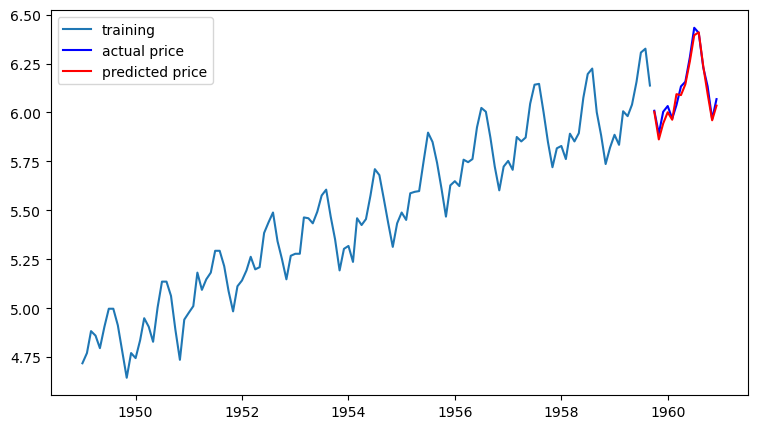

In [88]:
model = ARIMA(train_data, order=(13, 1, 0))  # p값을 13으로 테스트
fitted_m = model.fit()
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  203.20356364739277
MAE:  11.627992109415382
RMSE:  14.25494874236287
MAPE: 2.57%


p=14을 줄 경우 MAPE가 2.77%이지만 p=13을 줄 경우 MAPE가 2.57%로 더 내려간다.